In [ ]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import pandas as pd
import numpy as np

In [ ]:
import file_organizer as fo
from file_organizer import Meas

from func import ticks_handle
from func import fit_t1, fit_t2, fit_t2c

In [ ]:
path = "data_day_three"
file_list = fo.load_file_list(path)

In [ ]:
selection = (fo.select_files(file_list,'meas','P'))
# load data to pd.dataFrame
data1 = fo.load_files(selection)
data1 = fo.df_combine(data1)
data1["time"] = data1["time"] * 1000
# data.info()
del(data1['iout'])
del(data1['qout'])
names1 = list(data1.columns)
names1.remove('time')

## FID

In [ ]:
from lmfit import Model
def fit_t2(t, y, log=False):
    def t2func(t,M0,T2,c):#
        
        return M0*np.exp(-t/T2)+c

    model = Model(t2func, nan_policy='omit')
    res = model.fit(y, t=t, M0=6,T2=0.05,c=1)
    if log: print(res.fit_report())
    return res


In [ ]:
zero = (data1['time']-0.1).abs().idxmin()
end = (data1['time']-0.8).abs().idxmin()
res = fit_t2(np.array(data1.loc[zero:end, 'time']), np.array(data1.loc[zero:end, names1[0]]), log=False)

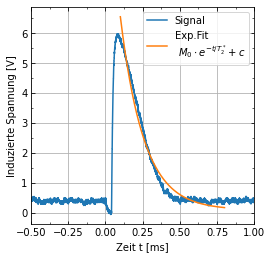

FLUOR T2*
[[Model]]
    Model(t2func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 38
    # data points      = 3501
    # variables        = 3
    chi-square         = 171.898136
    reduced chi-square = 0.04914183
    Akaike info crit   = -10545.6704
    Bayesian info crit = -10527.1880
[[Variables]]
    M0:  12.1761874 +/- 0.06157000 (0.51%) (init = 6)
    T2:  0.15777551 +/- 9.0915e-04 (0.58%) (init = 0.05)
    c:   0.09458462 +/- 0.00830828 (8.78%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(M0, T2) = -0.890
    C(T2, c)  = -0.798
    C(M0, c)  = 0.528


In [ ]:
fig,ax = plt.subplots(figsize=(4,4))
ax.plot(data1.loc[:,'time'], data1.loc[:, names1[0]], label='Signal')
ax.plot(data1.loc[zero:end,'time'], res.best_fit, label='Exp.Fit\n $M_0\\cdot e^{{-t/T_2^*}}+c$')

ax.set_xlim(-0.5,1)
ax.set_xlabel('Zeit t [ms]')
ax.set_ylabel('Induzierte Spannung [V]')
ticks_handle(ax, which='both')
ax.grid()
ax.legend()
fig.savefig('IMAGES/fluor_fid.png', dpi=300,bbox_inches='tight')
plt.show()
print('FLUOR T2*')
print(res.fit_report())

## T1 periode

In [ ]:
Ps = np.array([float(m.P) for m in selection])
Ms = np.array([data1[n].max() for n in names1])
res = fit_t1(Ps, Ms)

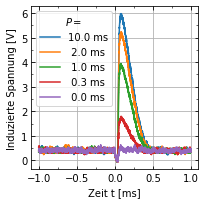

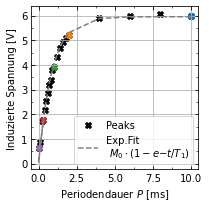

FLUOR T1
[[Model]]
    Model(fitfunc)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 34
    # data points      = 21
    # variables        = 2
    chi-square         = 0.87048199
    reduced chi-square = 0.04581484
    Akaike info crit   = -62.8478435
    Bayesian info crit = -60.7587986
[[Variables]]
    M0:  5.95528905 +/- 0.10256163 (1.72%) (init = 10)
    T1:  0.89630874 +/- 0.04053815 (4.52%) (init = 10)
[[Correlations]] (unreported correlations are < 0.100)
    C(M0, T1) = 0.738


In [ ]:
split=True
if split:
    fig1,ax = plt.subplots(figsize=(3,3))
    fig2,bx = plt.subplots(figsize=(3,3))
else:
    fig,(ax,bx) = plt.subplots(1,2, figsize=(6,3), sharey=True)
sel = [0, 4, 9, -1,-2]
data1.plot(x='time', y=[names1[i] for i in sel],
           label=[f'{Ps[i]:4.1f} ms' for i in sel], ax=ax)

bx.scatter(Ps,Ms, marker='X', color='black', label='Peaks')
for i in sel:
    bx.scatter(Ps[i] ,Ms[i], marker='X')
bx.plot(Ps, res.best_fit, color='gray',ls='--',label='Exp.Fit\n $M_0\\cdot(1-e{{-t/T_1}})$')


ax.set_xlabel('Zeit t [ms]')
ax.set_ylabel('Induzierte Spannung [V]')
bx.set_xlabel('Periodendauer $P$ [ms]')
for xx in [ax, bx]:
    xx.legend()
    xx.set_ylabel('Induzierte Spannung [V]')
    ticks_handle(xx, which='both')
    xx.grid()
ax.legend(title='$P = $')

if split:
    fig1.savefig('IMAGES/fluor_t1a.png', dpi=300,bbox_inches='tight')
    fig2.savefig('IMAGES/fluor_t1b.png', dpi=300,bbox_inches='tight')
else:
    fig.savefig('IMAGES/fluor_t1.png', dpi=300,bbox_inches='tight')
plt.show()
print('FLUOR T1')
print(res.fit_report())

## Fourier

In [ ]:
selection = fo.select_files(file_list, "meas", "Q")
liste = fo.load_files(selection)
liste = liste[1:]

#data = fo.df_combine(data)
#del data["iout"]

#data["time"]=data["time"]*1000
#label = list(data.columns)
#label.remove('time')
#print(liste[0]["time"].to_string())


In [ ]:
def read_with_fourier(meas: Meas):
    filename = path+ '/' + meas.filename
    df = pd.read_csv(filename)
    df.columns = [fo.parse_column_name(c) for c in df.columns]
    idx = df[df['time'].str.isalpha()].index
    df1 = df.loc[idx[0]+1:idx[1]-2,:].copy()
    df2 = df.loc[idx[1]+1:,:].copy()
    label = list(df.columns)
    for n in label:
        df1.loc[:,n] = df1.loc[:,n].astype('float')        
        df2[n] = df2[n].astype('float')
    return df1, df2

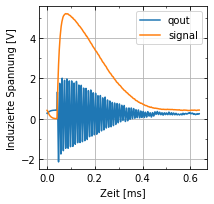

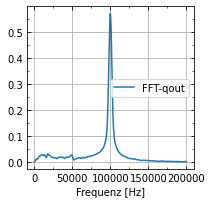

In [ ]:
df1, df2 = read_with_fourier(selection[2])
df1 = df1[df1["time"]>0]
df1["time"] = df1["time"]*1000

if split:
    fig1,ax = plt.subplots(figsize=(3,3))
    fig2,bx = plt.subplots(figsize=(3,3))
else:
    fig,(ax,bx) = plt.subplots(1,2, figsize=(6,3))
    
df1.plot(x='time',ax=ax)
df2.plot(x='time',ax=bx)

ax.set_ylabel("Induzierte Spannung [V]")
ax.set_xlabel("Zeit [ms]")
if not split: ax.set_title("Verstimmtes Fluor-NMR-Signal")
bx.set_xlabel("Frequenz [Hz]")
bx.legend(["FFT-qout"])
if not split: bx.set_title("FFT-Analyse von Q-wout")
ticks_handle(ax, which='both')
ticks_handle(bx, which='both')
ax.grid()
bx.grid()

if split:
    fig1.savefig('IMAGES/fluor_fft_b.png', dpi=300,bbox_inches='tight')
    fig2.savefig('IMAGES/fluor_fft_a.png', dpi=300,bbox_inches='tight')
else:
    fig.savefig('IMAGES/fluor_fft.png', dpi=300,bbox_inches='tight')
plt.show()

### FourierTrafo --> verworfen ;)

In [ ]:
from scipy.fft import fft, fftfreq, ifft, rfft, irfft, rfftfreq
N= df1.size #sample size
T = df1["time"][2365]-df1["time"][2364] #sample spacing, inverse rate
print("Samplingrate")
print(f"{1/T:.3E}")

Samplingrate
6.250E+03


In [ ]:
rfft(df1["qout"].to_numpy())
xf= rfftfreq(N//2, T)

In [ ]:
for d in liste:
    3d["time"]=d["time"]*1000
    d.plot(x='time', y='qout')

SyntaxError: invalid syntax (<ipython-input-16-9065ff665329>, line 2)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c333ff75-d5d2-432c-b928-cf45631da0c3' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>